## Connect Google Drive
Mount google drive to:
- Load dataset
- Store and load model checkpoints

In [1]:
from google.colab import drive, runtime
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ! 7z x '/content/drive/MyDrive/Research Credit/IPAD_dataset.zip'

! unzip -q '/content/drive/MyDrive/Research Credit/IPAD_dataset.zip' 'IPAD_dataset/R01/*'

In [3]:
import os
import torch

torch.manual_seed(0)

SEQ_LEN = 10
EPOCHS = 10
BATCH_SIZE = 7
SCALES = [2, 4, 8, 10]

DATA_ROOT = "/content/IPAD_dataset/R01"
RC_ROOT = "/content/drive/MyDrive/Research Credit"

TRAIN_DIR = f"{DATA_ROOT}/training/frames"
TEST_DIR = f"{DATA_ROOT}/testing/frames"
LABELS_PATH = f"{DATA_ROOT}/test_label"

NUM = len(os.listdir(f"{RC_ROOT}/Models"))
CKPT_PATH = f"{RC_ROOT}/Models/ckpt_{SEQ_LEN}_{NUM}.pth"
TEST_SAVE_PATH = f"{RC_ROOT}/Results/res_{NUM}.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define PyTorch Dataset
- Load a sequence of frames from the given root directory.
- Apply transforms.
- Convert frames into 768-D embeddings using ViT.

Returns the embedding and the original image for loss calculation.

In [4]:
import math

from PIL import Image
from torchvision.datasets import DatasetFolder
from torchvision.transforms import ToTensor, Resize, Compose
from torch.utils.data import Dataset, DataLoader
from transformers import ViTImageProcessor, ViTModel

transform = Compose([
    Resize((224, 224)),
    ToTensor()
])

def load_image(path):
    image = Image.open(path).convert("RGB")
    return image

img_label_dataset = DatasetFolder(
    root=TRAIN_DIR,
    loader=load_image,
    is_valid_file=lambda x: True
)

class ImgDataset(Dataset):
    def __init__(self, dataset, seq_len=SEQ_LEN):
        self.dataset = dataset
        self.seq_len = seq_len

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
        self.model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to(self.device)

    def __len__(self):
        return math.ceil(len(self.dataset) / self.seq_len)

    def __getitem__(self, idx):
        start_idx = idx * self.seq_len
        end_idx = min(start_idx + self.seq_len, len(self.dataset))
        sequence = [self.dataset[i] for i in range(start_idx, end_idx)]
        labels = [data[1] for data in sequence]
        is_valid = all(label == labels[0] for label in labels)
        if is_valid:
            images = torch.stack([transform(data[0]) for data in sequence])
            if len(images) < self.seq_len:
                images = torch.cat([images, torch.zeros(self.seq_len - len(images), 3, 224, 224)])
        else:
            images = torch.zeros(self.seq_len, 3, 224, 224)

        inputs = self.processor(
            images=images,
            return_tensors="pt"
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        outputs = self.model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        encoding = last_hidden_states[:, 0, :]

        return encoding, images

In [5]:
from torch import nn

class MultiScaleTemporalAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, device, scales=SCALES):
        super().__init__()
        self.scales = scales
        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim, num_heads).to(device) for _ in scales
        ])

    def forward(self, x):
        B, T, D = x.shape
        outputs = []

        for i, window_size in enumerate(self.scales):
            attn_device = next(self.attention_layers[i].parameters()).device
            if window_size >= T:
                q = k = v = x.transpose(0, 1).to(attn_device)
                attn_output, _ = self.attention_layers[i](q, k, v)
                outputs.append(attn_output.transpose(0, 1))
            else:
                local_outputs = []
                for start in range(T - window_size + 1):
                    chunk = x[:, start:start + window_size, :].to(attn_device)
                    q = k = v = chunk.transpose(0, 1)
                    attn_output, _ = self.attention_layers[i](q, k, v)
                    local_outputs.append(attn_output.mean(0))
                local_output = torch.stack(local_outputs, dim=1)
                local_output = F.interpolate(local_output.transpose(1, 2), size=T, mode='linear').transpose(1, 2)
                outputs.append(local_output)

        final_output = torch.stack(outputs, dim=0).mean(0)
        return final_output  # (B, T, D)

class CNNFrameReconstructor(nn.Module):
    def __init__(self, embed_dim=768, feature_dim=512, out_channels=3, img_size=224):
        super(CNNFrameReconstructor, self).__init__()
        self.img_size = img_size
        self.feature_dim = feature_dim
        self.out_channels = out_channels

        self.fc = nn.Linear(embed_dim, feature_dim * (img_size // 16) * (img_size // 16))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(feature_dim, feature_dim // 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(feature_dim // 2, feature_dim // 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(feature_dim // 4, feature_dim // 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(feature_dim // 8, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        x: (B, 50, embed_dim)
        Output: (B, 50, C, H, W)
        """
        B, T, D = x.shape
        x = x.view(B * T, D)
        x = self.fc(x)
        x = x.view(B * T, self.feature_dim, self.img_size // 16, self.img_size // 16)
        x = self.decoder(x)
        x = x.view(B, T, self.out_channels, self.img_size, self.img_size)
        return x

class FrameReconstructionModel(nn.Module):
    def __init__(self, device):
        super(FrameReconstructionModel, self).__init__()
        self.attn = MultiScaleTemporalAttention(
            embed_dim=768,
            num_heads=4,
            device=device,
            scales=[5, 10, 20]
        ).to(device)
        self.reconstructor = CNNFrameReconstructor().to(device)

    def forward(self, x):
        x = self.attn(x)
        x = self.reconstructor(x)
        return x.float()

# Training

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Number of samples: 781


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


SuggestedLRs(valley=0.0012022644514217973)

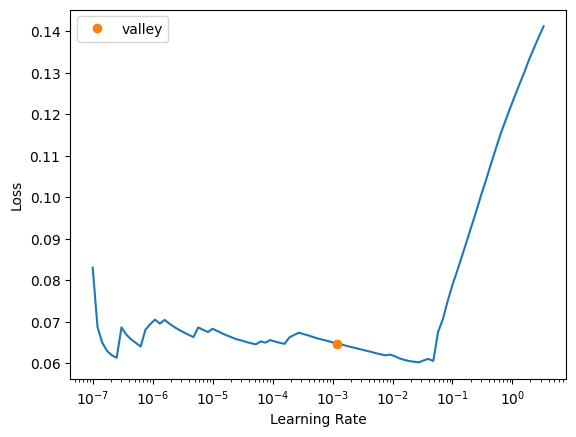

In [6]:
from fastai.vision.learner import Learner
from torch.utils.data import random_split
from fastai.vision.all import *

dataset = ImgDataset(img_label_dataset)
print(f"Number of samples: {len(dataset)}")

model = FrameReconstructionModel(device=device).to(device)
loss_func = MSELossFlat()

train_size = int(0.85 * len(dataset))
valid_size = len(dataset) - train_size
train_ds, valid_ds = random_split(dataset, [train_size, valid_size])

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
dls = DataLoaders(train_dl, valid_dl)

learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=Adam)

learn.lr_find()

In [7]:
learn.fine_tune(EPOCHS, cbs=[
    SaveModelCallback(monitor='valid_loss', fname=CKPT_PATH, every_epoch=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=2)
])

epoch,train_loss,valid_loss,time
0,0.042595,0.025356,04:25


epoch,train_loss,valid_loss,time
0,0.020308,0.018873,04:25
1,0.018898,0.016876,04:25
2,0.017662,0.014160,04:25
3,0.014971,0.013070,04:25
4,0.013474,0.012478,04:25
5,0.012284,0.011564,04:25
6,0.011979,0.011299,04:25
7,0.011000,0.011399,04:24


No improvement since epoch 5: early stopping


In [8]:
torch.save(learn.model.state_dict(), CKPT_PATH)
print(f"Model saved to {CKPT_PATH}")

Model saved to /content/drive/MyDrive/Research Credit/Models/ckpt_10_1.pth


# Testing

In [9]:
import os

import torch
import numpy as np

def load_model_from_ckpt(state_dict_path: str):
    model = FrameReconstructionModel(device=device)
    model.load_state_dict(torch.load(state_dict_path, map_location="cpu", weights_only=False))

    return model

def load_test_frames(test_dir: str, seq_len: int):
    test_dataset = DatasetFolder(
        root=test_dir,
        loader=load_image,
        transform=Compose([
            Resize((224, 224)),
            ToTensor()
        ]),
        is_valid_file=lambda x: True
    )

    test_dataset = ImgDataset(test_dataset, seq_len=seq_len)

    return test_dataset

def load_labels(labels_path: str, seq_len: int):
    label_files = os.listdir(labels_path)
    labels = []
    for label_file in label_files:
        label = np.load(f"{labels_path}/{label_file}")
        labels.append(label)

    labels = np.hstack(labels)
    labels = labels.tolist()

    labels_seq = []
    for i in range(0, len(labels), seq_len):
        temp = labels[i:i+seq_len]
        if all(label == temp[0] for label in temp):
            labels_seq.append(1)
        else:
            labels_seq.append(0)

    return labels_seq

In [10]:
from tqdm import tqdm
import pandas as pd
from fastai.vision.all import *

test_dataset = load_test_frames(TEST_DIR, SEQ_LEN)
test_labels = load_labels(LABELS_PATH, SEQ_LEN)

# model = load_model_from_ckpt("/content/drive/MyDrive/Research Credit/Models/ckpt_10_0.pth")
model = load_model_from_ckpt(CKPT_PATH)
model.to(device)
model.eval()

loss_func = MSELossFlat()

errors = []
for i in tqdm(range(len(test_dataset))):
    embed, image = test_dataset[i]
    embed, image = embed.to(device).unsqueeze(0), image.to(device).unsqueeze(0)

    with torch.no_grad():
        reconstructed = model(embed)
        error = loss_func(reconstructed, image)
    errors.append(error.cpu().item())

    del embed, image, reconstructed, error
    torch.cuda.empty_cache()

100%|██████████| 369/369 [01:26<00:00,  4.27it/s]


In [11]:
if len(errors) == len(test_labels):
    result_df = pd.DataFrame({
        "error": errors,
        "label": test_labels
    })
    result_df.to_csv(TEST_SAVE_PATH, index=False)
    print(f"Test results saved to {TEST_SAVE_PATH}.")

else:
    print("Results saving failed.")

Test results saved to /content/drive/MyDrive/Research Credit/Results/res_1.csv.


### Analysis

In [12]:
import pandas as pd

test_df = pd.read_csv(TEST_SAVE_PATH)
test_df.head()

,error,label
0,0.014488,0
1,0.014769,1
2,0.015058,1
3,0.015185,1
4,0.015072,1


In [13]:
import numpy as np
from sklearn.metrics import roc_curve

errors = test_df['error'].values
labels = test_df['label'].values

fpr, tpr, thresholds = roc_curve(labels, errors)

j_scores = tpr - fpr

optimal_threshold = thresholds[np.argmax(j_scores)]

print(f"Optimal threshold: {optimal_threshold}")

Optimal threshold: 0.014686357229948


In [14]:
import numpy as np
from sklearn.metrics import roc_curve, auc

optimal_threshold_idx = np.where(thresholds == optimal_threshold)[0][0]

auc_at_best_threshold = auc(fpr[:optimal_threshold_idx+1], tpr[:optimal_threshold_idx+1])

print(f"AUC at best threshold: {auc_at_best_threshold}")

AUC at best threshold: 0.027062374245472837


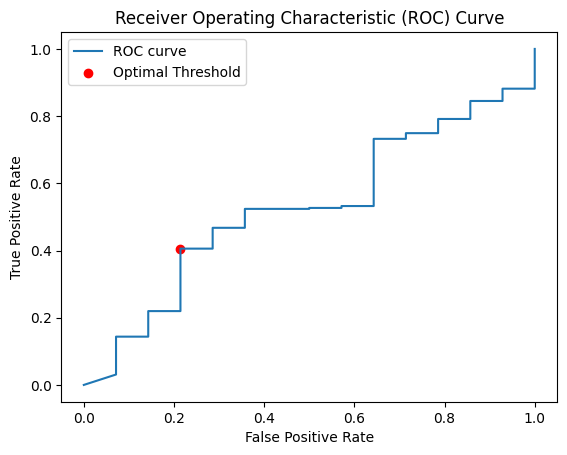

In [15]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve')
plt.scatter(fpr[np.argmax(j_scores)], tpr[np.argmax(j_scores)], marker='o', color='red', label='Optimal Threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [16]:
drive.flush_and_unmount()
runtime.unassign()